In [29]:
import numpy as np
import pandas as pd
import healpy as hp

import matplotlib.pyplot as plt
%matplotlib inline



In [30]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)

Fields = pd.DataFrame()
Fields['pixId'] = np.arange(NPIX)
Fields['fieldRa'], Fields['fieldDec'] = pix2radec(nside=NSIDE, ipix=Fields['pixId'].values )
Fields['fieldGl'], Fields['fieldGb'] = radec2gal(ra=Fields['fieldRa'].values, dec=Fields['fieldDec'].values)
Fields['fieldEl'], Fields['fieldEb'] = radec2ecliptic(ra=Fields['fieldRa'].values, dec=Fields['fieldDec'].values)



In [51]:
for ii in range(10):
    print(ii, hp.nside2npix(ii))

0 0
1 12
2 48
3 108
4 192
5 300
6 432
7 588
8 768
9 972


In [36]:
def get_dens(df): 
    dens = get_starDensity(ra=df['fieldRa'], dec=df['fieldDec'], starMap=starmap, mag=25)
    if df['pixId']%1000 == 0:
        print(df['pixId'])
    return dens

In [52]:
Fields.describe()

,pixId,fieldRa,fieldDec,fieldGl,fieldGb,fieldEl,fieldEb,starDensity_r25
count,49152.000000,49152.000000,4.915200e+04,49152.000000,4.915200e+04,49152.000000,4.915200e+04,4.915200e+04
mean,24575.500000,179.765625,1.434616e-15,179.946011,1.197299e-14,179.996132,1.591754e-08,1.026679e+05
std,14189.104552,103.921602,3.917055e+01,103.923847,3.917178e+01,103.920229,3.917120e+01,4.189378e+05
min,0.000000,0.000000,-8.926903e+01,0.006848,-8.953034e+01,0.018220,-8.943331e+01,0.000000e+00
25%,12287.750000,89.824219,-3.000000e+01,89.918160,-3.001427e+01,90.002354,-3.001403e+01,5.364000e+03
50%,24575.500000,179.648438,0.000000e+00,179.988218,3.578124e-14,179.998404,1.618052e-07,1.130400e+04
75%,36863.250000,269.472656,3.000000e+01,269.917553,3.001427e+01,269.989913,3.001322e+01,4.072500e+04
max,49151.000000,359.296875,8.926903e+01,359.969589,8.953034e+01,359.969512,8.943289e+01,1.548551e+07


In [53]:
Fields

,pixId,fieldRa,fieldDec,fieldGl,fieldGb,fieldEl,fieldEb,starDensity_r25,extra_gal
0,0,45.0,89.269029,123.366479,26.508638,88.737376,66.038053,0,True
1,1,135.0,89.269029,123.629810,27.515401,91.282889,66.037822,0,True
2,2,225.0,89.269029,122.492534,27.746514,91.337556,67.071334,0,True
3,3,315.0,89.269029,122.238877,26.737678,88.683896,67.071577,0,True
4,4,22.5,88.538029,123.203575,25.686667,86.692348,65.965065,0,True
...,...,...,...,...,...,...,...,...,...
49147,49147,337.5,-88.538029,303.892920,-28.317265,273.299594,-65.963158,30744,True
49148,49148,45.0,-89.269029,302.492534,-27.746514,271.308217,-67.069650,28872,True
49149,49149,135.0,-89.269029,302.238877,-26.737678,268.654805,-67.069407,31968,True
49150,49150,225.0,-89.269029,303.366479,-26.508638,268.709465,-66.035910,34812,True


In [57]:
load

In [37]:
# load a builtin star map
# only have star density for LSST footprint
starmap = load_starmap(flt='r')

# %%time 
Fields['starDensity_r25'] = Fields.apply(get_dens, axis=1)
Fields.to_csv("Fields_nside{}.csv".format(NSIDE), index=False)
print('Finish!')

a
0.0
1000.0
2000.0
3000.0
4000.0
5000.0
6000.0
7000.0
8000.0
9000.0
10000.0
11000.0
12000.0
13000.0
14000.0
15000.0
16000.0
17000.0
18000.0
19000.0
20000.0
21000.0
22000.0
23000.0
24000.0
25000.0
26000.0
27000.0
28000.0
29000.0
30000.0
31000.0
32000.0
33000.0
34000.0
35000.0
36000.0
37000.0
38000.0
39000.0
40000.0
41000.0
42000.0
43000.0
44000.0
45000.0
46000.0
47000.0
48000.0
49000.0
b
c


In [38]:
Fields['extra_gal'] = ( Fields['fieldGb'] > 20 ) | ( Fields['fieldGb'] < -20 )

In [58]:
np.unique( Fields['extra_gal'].values, return_counts=True )

(array([False,  True]), array([16782, 32370]))

In [39]:
_, (Ngal, N_extragal) = np.unique( Fields['extra_gal'].values, return_counts=True )

In [40]:
area_gal = Ngal * hp.nside2pixarea(64, degrees=True)
area_extragal = N_extragal * hp.nside2pixarea(64, degrees=True)

In [41]:
area_gal, area_extragal

(14085.0259539338, 27167.93529548547)

/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/projections/geo.py:421: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


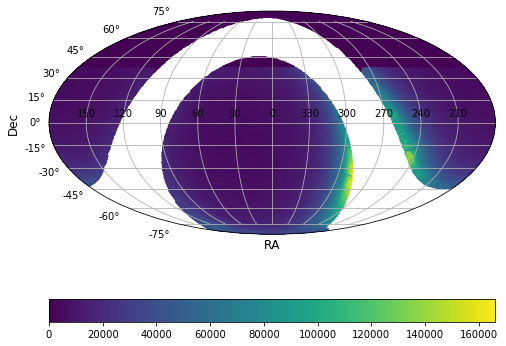

In [62]:
df = Fields

fig, ax = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 

# remove by galactic coordinate
extra_gal = Fields['extra_gal'].values

df = df[extra_gal]
x = df['fieldRa']
y = df['fieldDec']
c = df['starDensity_r25']
plot_mwd(ax, x, y, c, title='') 



/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/projections/geo.py:421: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


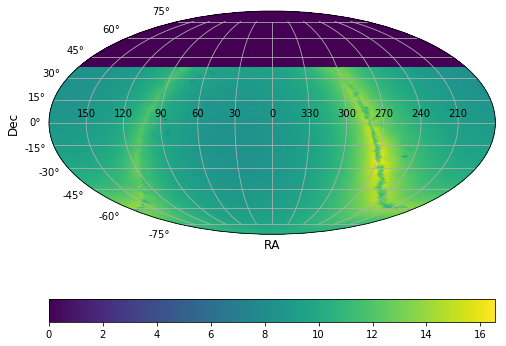

In [65]:
df = Fields

fig, ax = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 

# remove by galactic coordinate
# extra_gal = Fields['extra_gal'].values

# df = df[extra_gal]
x = df['fieldRa']
y = df['fieldDec']
# c = df['starDensity_r25']
c = np.log(df['starDensity_r25']+1)
plot_mwd(ax, x, y, c, title='') 



### utils

In [7]:
def plot_mwd(ax, RA, Dec, c, org=0, title='Mollweide projection', projection='mollweide', vmin=None, vmax=None, colorbar=True):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': 'mollweide'}); 
        plot_mwd(ax, x, y, c, title='') 
    '''
    if vmax is None:
        vmax = c.max()
    if vmin is None:
        vmin = c.min()
    
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    # ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, marker='o', vmin=vmin, vmax=vmax)  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    if colorbar:
        cbar = plt.colorbar(sc, ax=ax, orientation="horizontal")
    #cbar.set_clim(-2.0, 2.0)

# ------------------------------------------------------------------- #
# builtin star density map
# ------------------------ #
import os
import healpy as hp
from lsst.utils import getPackageDir
from scipy.interpolate import interp1d
from lsst.sims.maf.utils import radec2pix

def load_starmap(flt='r'):
    # get mapdir '/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maps/2017.05.08-4-gac432e6/StarMaps'
    mapDir = os.path.join(getPackageDir('sims_maps'),'StarMaps') 

    mapfile = 'starDensity_{}_nside_64.npz'.format(flt)

    starMap = np.load( os.path.join(mapDir, mapfile) )
    
    return starMap
      
def get_starDensity(ra=0, dec=0, starMap=None, mag=25):
    '''get star density of a field, from star density map,
    input ra, dec in degree 
    returns stars / (sq degree)
    '''
    ra = ra * np.pi / 180   # convert to radian
    dec = dec * np.pi / 180

    starMapDensity = starMap['starDensity'].copy()
    starMapBins = starMap['bins'].copy()
    starmapNside = hp.npix2nside( np.size(starMapDensity[:,0]) )
    
    ipix = radec2pix(starmapNside, ra, dec) # convert from ra/dec to ipix 
    density = interp1d( starMapBins[1:], starMapDensity[ipix, :] ) (mag)
    return int( density )

#-----------------------------------
# coordinates transform
def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec
    
def radec2ecliptic(ra, dec):
    '''convert from ra/dec to galactic l/b'''
    from astropy.coordinates import GeocentricTrueEcliptic
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    c = SkyCoord(ra=ra, dec=dec, 
                 unit=(u.degree, u.degree))
    
    lon = c.transform_to(GeocentricTrueEcliptic()).lon.degree
    lat = c.transform_to(GeocentricTrueEcliptic()).lat.degree
    
    return lon, lat

def radec2gal(ra, dec):
    '''convert from ra/dec to galactic l/b'''
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    c = SkyCoord(ra=ra, dec=dec, 
                 unit=(u.degree, u.degree))
    
    l = c.galactic.l.degree
    b = c.galactic.b.degree
    return l, b

def gal2radec(gl, gb):
    '''convert gl/gb to ra/dec'''
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    c = SkyCoord(l=gl, b=gb, frame="galactic",
                unit=(u.degree, u.degree))
    ra = c.icrs.ra.degree
    dec = c.icrs.dec.degree
    return ra, dec

# redefined RADec2pix, default in degree 
def RADec2pix(nside, ra, dec, degree=True):
    """
    Calculate the nearest healpixel ID of an RA/Dec array, assuming nside.

    Parameters
    ----------
    nside : int
        The nside value of the healpix grid.
    ra : numpy.ndarray
        The RA values to be converted to healpix ids, in degree by default.
    dec : numpy.ndarray
        The Dec values to be converted to healpix ids, in degree by default.

    Returns
    -------
    numpy.ndarray
        The healpix ids.
    """
    if degree:
        ra = np.radians(ra) # change to radians
        dec = np.radians(dec)
    
    lat = np.pi/2. - dec
    hpid = hp.ang2pix(nside, lat, ra )
    return hpid

